## 11.1 Hyperparameters
In programming, a parameter lets us control
how a function behaves. Hyperparameters allow us to control how a machine-learning model
behaves.

Hyperparameters are values that control the behavior of the model and can be adjusted to improve its performance. Tuning hyperparameters involves finding the best values for them.

XGBoost has a large range of hyperparameters that can be classified into four distinct categories: General Parameters, Booster Parameters, Learning Task Parameters, and Command Line Parameters. General parameters guide the overall functioning of the model and relate to the booster being used. Booster parameters depend on the choice of the booster. Learning task parameters decide on the learning scenario. For example, regression tasks may use different parameters with ranking tasks. Command line parameters relate to behavior of CLI version of XGBoost.

### tree creation hyperparameters
* `'max_depth'` specifies the maximum depth of a tree and controls the complexity of the model. A larger value for max_depth allows for more feature interactions but increases the risk of overfitting. This one ranges from 0 to infinity.
* `'max_leaves'` specifies the maximum number of leaves in a tree and can be used to control model complexity. This one ranges from 0 to infinity.
* `'min_child_weight'` specifies the minimum sum of instance weight needed in a child and can be used to control overfitting by setting a larger value. This one ranges from 0 to infinity.
* `'grow_policy'` determines how new nodes are added to the tree and can be set to either “depthwise” or "lossguide"
* `'tree_method'` specifies the algorithm used for tree construction and can be set to “auto”, “exact”, “approx”, “hist”, or "gpu_hist".

### sampling hyperparameters
* `'colsample_bytree'`, `'colsample_bylevel'`, and `'colsample_bynode'` control the subsampling of columns at each tree, level, and node split respectively. These hyperparameters can be used to control overfitting by setting a value less than 1.
* `'subsample '`controls the subsampling of rows before each boosting round and can also be used to control overfitting by setting a value less than 1.01. When subsample is not equal to 1.0, the model performs stochastic gradient descent.

## 11.2 Examining Hyperparameters

In [1]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile

from EffectiveXGBoost import *

In [3]:
path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test = pline.transform(kag_X_test)

# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

# Default training
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
xg.get_params()

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:56: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

Validation curves are plots that show how the performance of the model changes as the value of a specific hyperparameter is changed. By looking at these plots, you can see which values of the hyperparameter yield the best results.

We will use our old friend `validation_curve` function from the `Yellowbrick` library to plot a validation curve for the `'gamma'` hyperparameter. _Gamma_ is a hyperparameter that controls how much a tree can grow. It limits growth unless a specified loss reduction is met. The larger the value of gamma, the more conservative or simple the model will be.

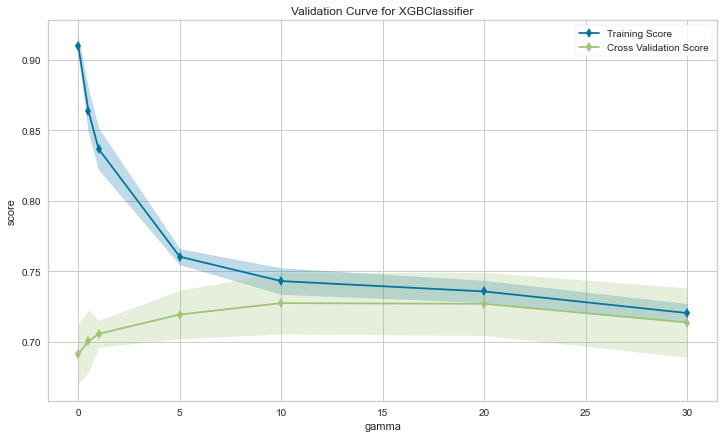

ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for XGBClassifier'}, xlabel='gamma', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, gamma=None,
                                        gpu_id=None, grow_poli...
                                        learning_rate=None, max_bin=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, reg_alpha=None,
                                        reg_lambda=None, ...),
                n_jobs=-1, param_name='gamma',
                param_range=array([ 0. ,  0.5,  1. ,  5. , 10. , 20. , 30. ]))

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train, param_name='gamma', param_range=[0, .5, 1,5,10, 20, 30], n_jobs=-1, ax=ax)

From the validation curve, spots between 10 and 20 all look good.

## 11.4 Intuitive Understanding of Learning Rate

You need to find the right balance for the learning_rate hyperparameter.

If you set the learning_rate too high, your model will be over-confident and over-fit the data. This means that it will memorize the training data instead of learning from it, and will not perform well on new data. On the other hand, if you set the learning_rate too low, your model will take too long to learn and may never reach its full potential.

Finding the right value for the learning_rate hyperparameter involves experimentation. You need to try different values and see which one gives you the best performance. 

In [7]:
# check impact of learning weight on scores
xg_lr1 = xgb.XGBClassifier(learning_rate=1, max_depth=2)
xg_lr1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

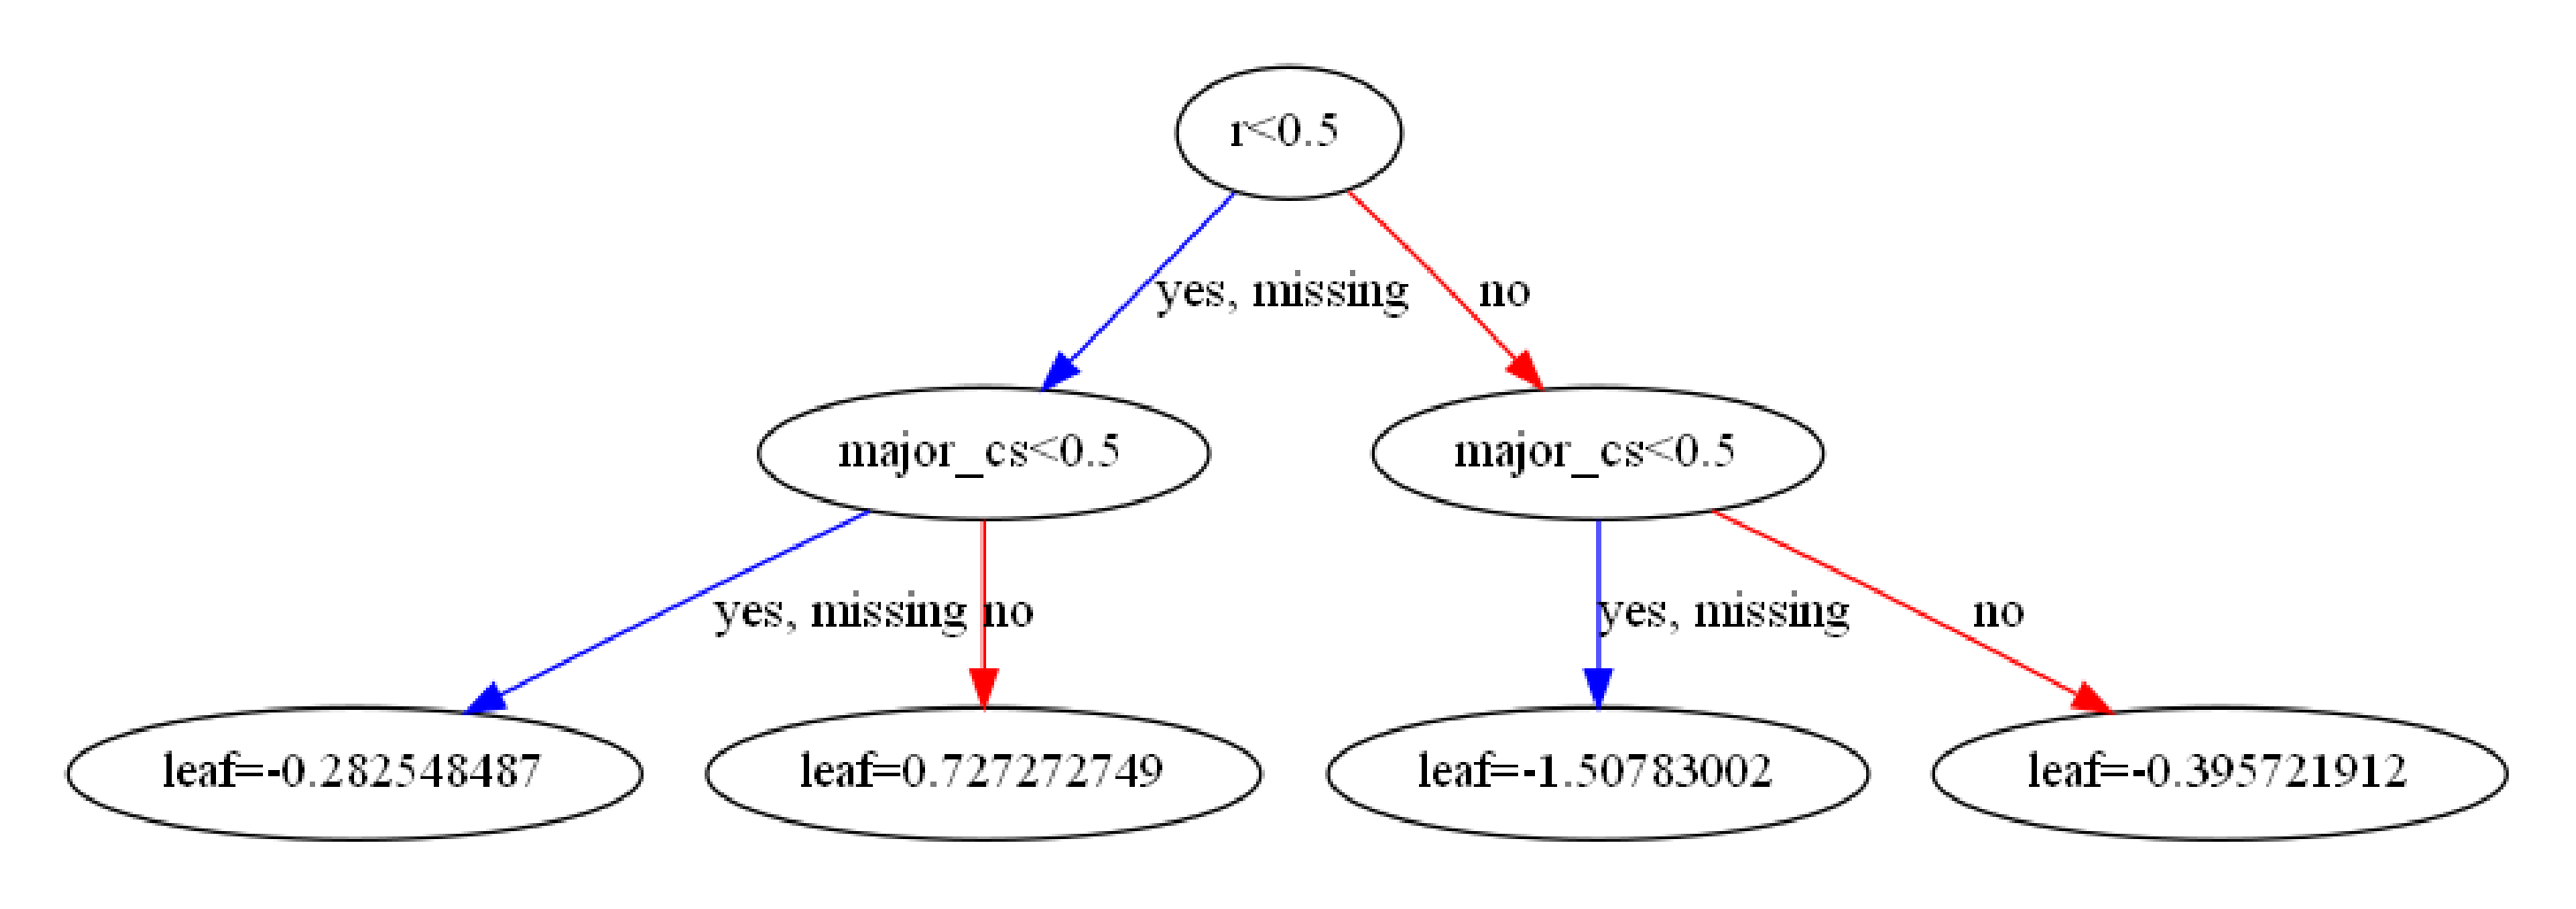

In [9]:
fig, ax = plt.subplots(figsize=(6,12), dpi=600)
_=xgb.plot_tree(xg_lr1, num_trees=0, ax=ax)

my_dot_export(xg_lr1, n_trees=0, filename='img/xg_depth2_tree0.dot',
title='Learning Rate set to 1')

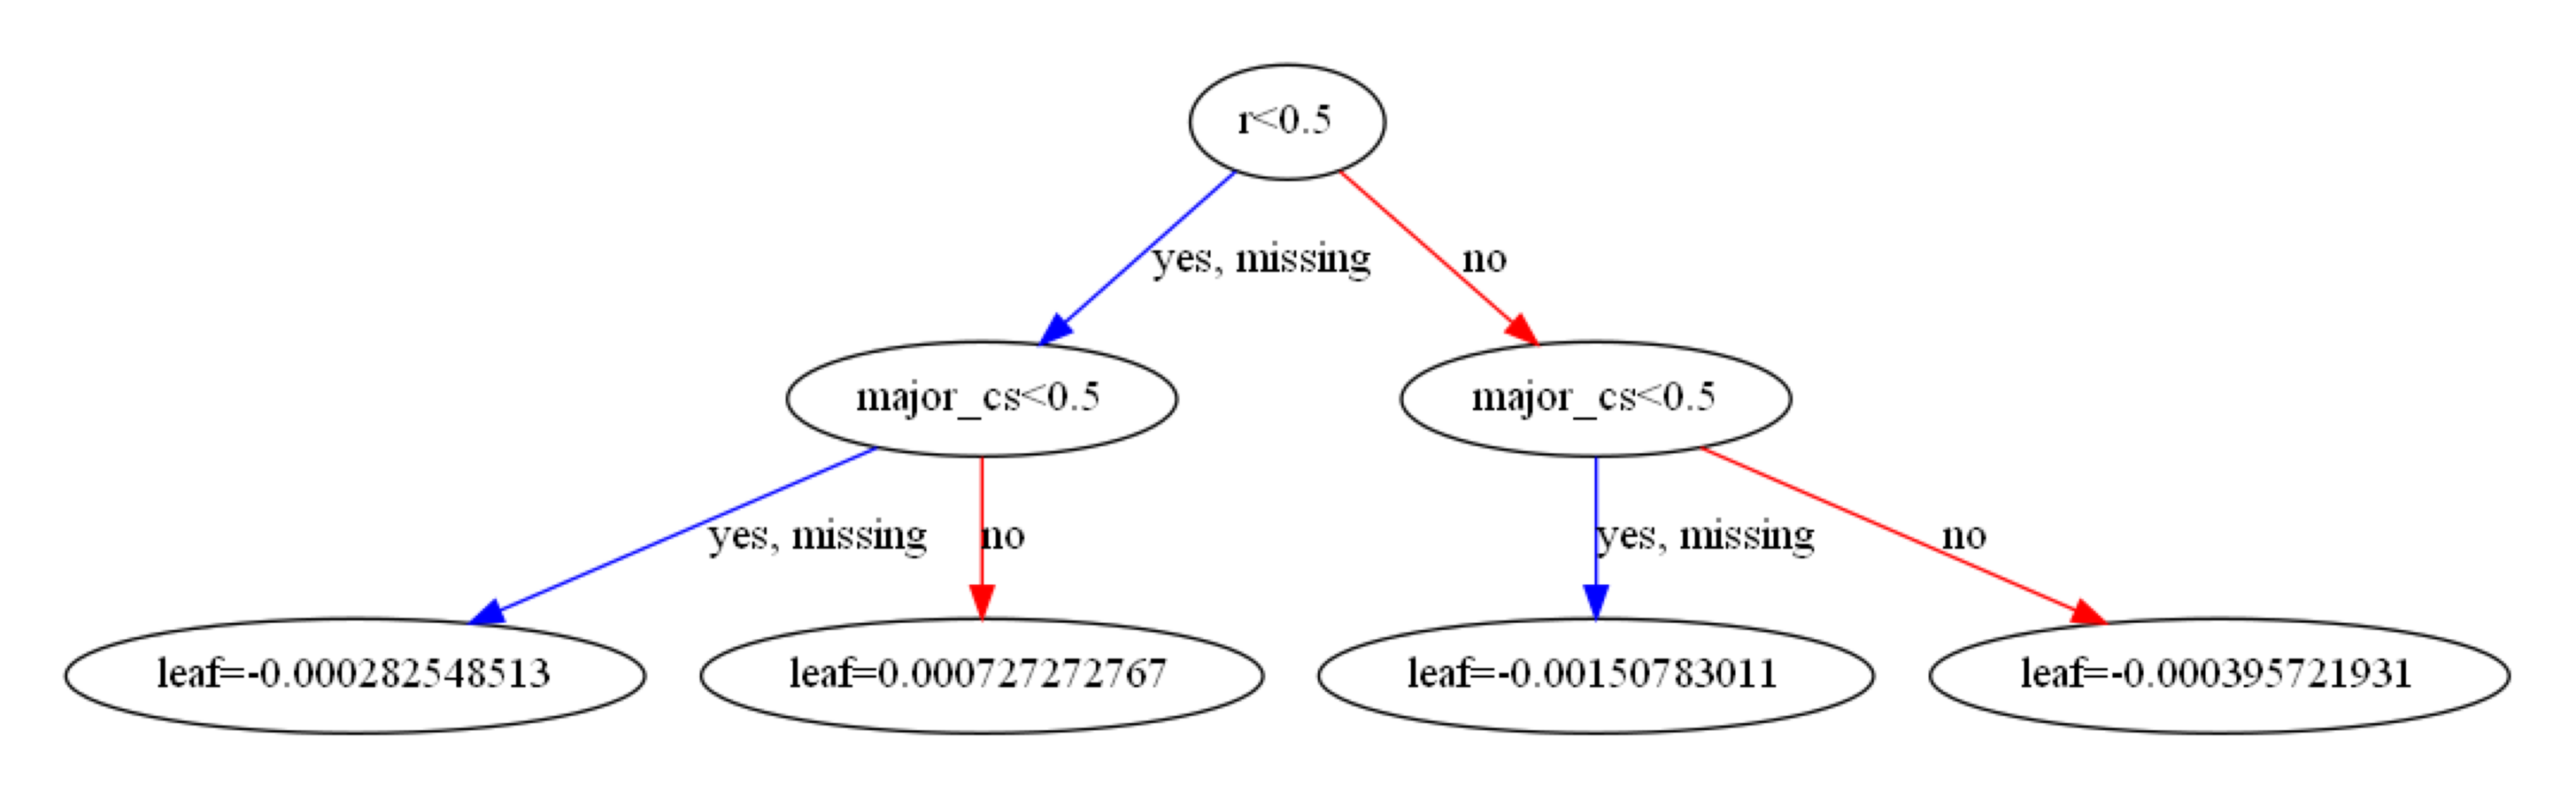

In [11]:
# check impact of learning weight on scores
xg_lr001 = xgb.XGBClassifier(learning_rate=.001, max_depth=2)
xg_lr001.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6,12), dpi=600)
_=xgb.plot_tree(xg_lr001, num_trees=0, ax=ax)

my_dot_export(xg_lr001, n_trees=0, filename='img/xg_depth2_tree0_lr001.dot',
title='Learning Rate set to .001')

## 11.5 Grid Search

Since there are many hyperparameters and some of them interact with each other, it can be difficult to know which combination of values will give the best performance.

One way to find the best combination of hyperparameters is to use a grid search. This involves trying all possible combinations of hyperparameter values and seeing which one gives the best performance. The `GridSearchCV` class from the scikit-learn library can help with this. You provide it with a mapping of hyperparameters to potential values for each hyperparameter, and it will loop through all combinations and keep track of the best ones.

However, grid search can be computationally expensive and time-consuming, especially when there are many hyperparameters to test and many possible values for each one. 

In [12]:
from sklearn import model_selection
params = {'reg_lambda': [0], # No effect
        'learning_rate': [.1, .3], # makes each boost more conservative
        'subsample': [.7, 1],
        'max_depth': [2, 3],
        'random_state': [42],
        'n_jobs': [-1],
        'n_estimators': [200]}
xgb2 = xgb.XGBClassifier(early_stopping_rounds=5)
cv = (model_selection.GridSearchCV(xgb2, params, cv=3, n_jobs=-1)
      .fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50))

# a dictionary of the hyperparameters with the best result
cv.best_params_

[0]	validation_0-logloss:0.64544
[33]	validation_0-logloss:0.50970


{'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}

In [13]:
params = {'learning_rate': 0.3,
'max_depth': 2,
'n_estimators': 200,
'n_jobs': -1,
'random_state': 42,
'reg_lambda': 0,
'subsample': 1
}
xgb_grid = xgb.XGBClassifier(**params, early_stopping_rounds=50)
xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)],verbose=10)

[0]	validation_0-logloss:0.64709	validation_1-logloss:0.64544
[10]	validation_0-logloss:0.54430	validation_1-logloss:0.53771
[20]	validation_0-logloss:0.52311	validation_1-logloss:0.51780
[30]	validation_0-logloss:0.51253	validation_1-logloss:0.51011
[40]	validation_0-logloss:0.50731	validation_1-logloss:0.50763
[50]	validation_0-logloss:0.50150	validation_1-logloss:0.50626
[60]	validation_0-logloss:0.49832	validation_1-logloss:0.50483
[70]	validation_0-logloss:0.49528	validation_1-logloss:0.50508
[80]	validation_0-logloss:0.49255	validation_1-logloss:0.50703
[90]	validation_0-logloss:0.48966	validation_1-logloss:0.50807
[100]	validation_0-logloss:0.48718	validation_1-logloss:0.50778
[110]	validation_0-logloss:0.48625	validation_1-logloss:0.50810


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0, ...)

In [18]:
# vs default
xgb_def = xgb.XGBClassifier(early_stopping_rounds=50)
xgb_def.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

xgb_def.score(X_test, y_test), xgb_grid.score(X_test, y_test)

[0]	validation_0-logloss:0.61534	validation_1-logloss:0.61775
[10]	validation_0-logloss:0.45062	validation_1-logloss:0.50430
[20]	validation_0-logloss:0.40872	validation_1-logloss:0.50839
[30]	validation_0-logloss:0.37945	validation_1-logloss:0.51352
[40]	validation_0-logloss:0.35009	validation_1-logloss:0.52234
[50]	validation_0-logloss:0.33692	validation_1-logloss:0.52726
[60]	validation_0-logloss:0.32142	validation_1-logloss:0.53397
[61]	validation_0-logloss:0.32072	validation_1-logloss:0.53429


(0.7558011049723757, 0.7524861878453039)

The default model performed slightly better than the model obtained through grid search. This can happen because the grid search used 3-fold cross-validation to find the best hyperparameters, but the final score was calculated against a single holdout set.

K-fold cross-validation is a technique used to evaluate the performance of a model. It involves splitting the data into k folds or groups. Then, for each fold, the model is trained on all the other folds and tested on the reserved fold. This process is repeated for each fold and the results are averaged to get a more accurate estimate of the model’s performance.

To run k-fold cross-validation outside of grid search, you can use the cross_val_score function from the scikit-learn library.

In [19]:
results_default = model_selection.cross_val_score(xgb.XGBClassifier(), X=X, y=y, cv=4)
results_default

array([0.71352785, 0.72413793, 0.69496021, 0.74501992])

In [20]:
results_default.mean()

0.7194114787534214

Let’s call cross_val_score again with a model created from our grid search hyperparameters.

In [21]:
results_grid = model_selection.cross_val_score(xgb.XGBClassifier(**params), X=X, y=y,cv=4)
print(results_grid)
results_grid.mean()

[0.74137931 0.74137931 0.74801061 0.73572377]


0.7416232505873941

Our grid search model here seems to perform better for these folds of the data; and the
scores across the folds look more consistent. Probably the case that the test set we held
out for `X_test` is easier for the default model to predict.